<a href="https://colab.research.google.com/github/7201krap/PYTORCH_introduction_to_pytorch/blob/main/FINAL_Sparsity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mnist_trainset = datasets.MNIST(root='./data', train=True, 
                                download=True, 
                                transform=transforms.Compose([transforms.ToTensor()]))

mnist_testset  = datasets.MNIST(root='./data', 
                                train=False, 
                                download=True, 
                                transform=transforms.Compose([transforms.ToTensor()]))

train_dataloader = torch.utils.data.DataLoader(mnist_trainset, 
                                               batch_size=50, 
                                               shuffle=True)

test_dataloader  = torch.utils.data.DataLoader(mnist_testset, 
                                               batch_size=50, 
                                               shuffle=False)

print("Training dataset size: ", len(mnist_trainset))
print("Testing dataset size: ",  len(mnist_testset))

Training dataset size:  60000
Testing dataset size:  10000


In [3]:
# Define the model 
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear_1 = torch.nn.Linear(784, 256)
        self.linear_2 = torch.nn.Linear(256, 10)
        self.sigmoid  = torch.nn.Sigmoid()

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.sigmoid(x)
        pred = self.linear_2(x)

        return pred

In [4]:
def get_activation(model):    
    def hook(module, input, output):
        model.layer_activations = output
    return hook

In [5]:
def sparsity_trainer(optimizer, model):

    # reset the model 

    criterion = torch.nn.CrossEntropyLoss()
    no_epochs = 20
    train_loss = list()
    test_loss  = list()
    test_acc   = list()
    final_spareness = list()

    # define activation list 

    best_test_loss = 1

    for epoch in range(no_epochs):
        total_train_loss = 0
        total_test_loss = 0

        hidden_layer_activation_list = list()

        # training
        # set up training mode 
        model.train()

        for itr, (image, label) in enumerate(train_dataloader):

            optimizer.zero_grad()

            pred = model(image)

            loss = criterion(pred, label)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()

            # Print/Append activation of the hidden layer 
            # print(model.layer_activations.shape)
            hidden_layer_activation_list.append(model.layer_activations)
        
        # this conains activations for all epochs 
        final_spareness.append(hidden_layer_activation_list)

        total_train_loss = total_train_loss / (itr + 1)
        train_loss.append(total_train_loss)

        # testing 
        # change to evaluation mode 
        model.eval()
        total = 0
        for itr, (image, label) in enumerate(test_dataloader):

            pred = model(image)

            loss = criterion(pred, label)
            total_test_loss += loss.item()

            # we now need softmax because we are testing.
            pred = torch.nn.functional.softmax(pred, dim=1)
            for i, p in enumerate(pred):
                if label[i] == torch.max(p.data, 0)[1]:
                    total = total + 1

        # caculate accuracy 
        accuracy = total / len(mnist_testset)

        # append accuracy here
        test_acc.append(accuracy)

        # append test loss here 
        total_test_loss = total_test_loss / (itr + 1)
        test_loss.append(total_test_loss)

        print('\nEpoch: {}/{}, Train Loss: {:.8f}, Test Loss: {:.8f}, Test Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_test_loss, accuracy))

        if total_test_loss < best_test_loss:
            best_test_loss = total_test_loss
            print("Saving the model state dictionary for Epoch: {} with Test loss: {:.8f}".format(epoch + 1, total_test_loss))
            torch.save(model.state_dict(), "model.dth")

    sparseness_list = list()

    for single_epoch_spareness in final_spareness:

        hidden_layer_activation_list = single_epoch_spareness
        hidden_layer_activation_list = torch.stack(hidden_layer_activation_list)
        layer_activations_list = torch.reshape(hidden_layer_activation_list, (60000, 256))

        layer_activations_list = torch.abs(layer_activations_list)  # modified 
        num_neurons = layer_activations_list.shape[1]
        population_sparseness = (np.sqrt(num_neurons) - (torch.sum(layer_activations_list, dim=1) / torch.sqrt(torch.sum(layer_activations_list ** 2, dim=1)))) / (np.sqrt(num_neurons) - 1)
        mean_sparseness_per_epoch = torch.mean(population_sparseness)

        sparseness_list.append(mean_sparseness_per_epoch)

    return test_acc, sparseness_list

In [6]:
# adagrad 
model_adagrad = Model()
model_adagrad.linear_1.register_forward_hook(get_activation(model_adagrad))
optimizer_adagrad  = torch.optim.Adagrad(model_adagrad.parameters(), lr=0.1)

# adadelta
model_adadelta = Model()
model_adadelta.linear_1.register_forward_hook(get_activation(model_adadelta))
optimizer_adadelta = torch.optim.Adagrad(model_adadelta.parameters(), lr=1)

# SGD 
model_sgd = Model()
model_sgd.linear_1.register_forward_hook(get_activation(model_sgd))
optimizer_sgd      = torch.optim.SGD(model_sgd.parameters(), lr=0.1)

In [7]:
print("\n===== Entering Adagrad optimizer =====\n")
adagrad_test_acc, adagrad_sparseness_list   = sparsity_trainer(optimizer=optimizer_adagrad,
                                                               model=model_adagrad)

print("\n===== Entering Adadelta optimizer =====\n")
adadelta_test_acc, adadelta_sparseness_list = sparsity_trainer(optimizer=optimizer_adadelta,
                                                               model=model_adadelta)

print("\n===== Entering SGD optimizer =====\n")
sgd_test_acc, sgd_sparseness_list           = sparsity_trainer(optimizer=optimizer_sgd,
                                                               model=model_sgd)


===== Entering Adagrad optimizer =====


Epoch: 1/20, Train Loss: 0.24943174, Test Loss: 0.13392499, Test Accuracy: 0.95940000
Saving the model state dictionary for Epoch: 1 with Test loss: 0.13392499

Epoch: 2/20, Train Loss: 0.10454792, Test Loss: 0.10542158, Test Accuracy: 0.96790000
Saving the model state dictionary for Epoch: 2 with Test loss: 0.10542158

Epoch: 3/20, Train Loss: 0.07366425, Test Loss: 0.09006167, Test Accuracy: 0.97120000
Saving the model state dictionary for Epoch: 3 with Test loss: 0.09006167

Epoch: 4/20, Train Loss: 0.05585397, Test Loss: 0.08516948, Test Accuracy: 0.97330000
Saving the model state dictionary for Epoch: 4 with Test loss: 0.08516948

Epoch: 5/20, Train Loss: 0.04419098, Test Loss: 0.07594403, Test Accuracy: 0.97610000
Saving the model state dictionary for Epoch: 5 with Test loss: 0.07594403

Epoch: 6/20, Train Loss: 0.03565788, Test Loss: 0.07471877, Test Accuracy: 0.97750000
Saving the model state dictionary for Epoch: 6 with Test loss: 0.07

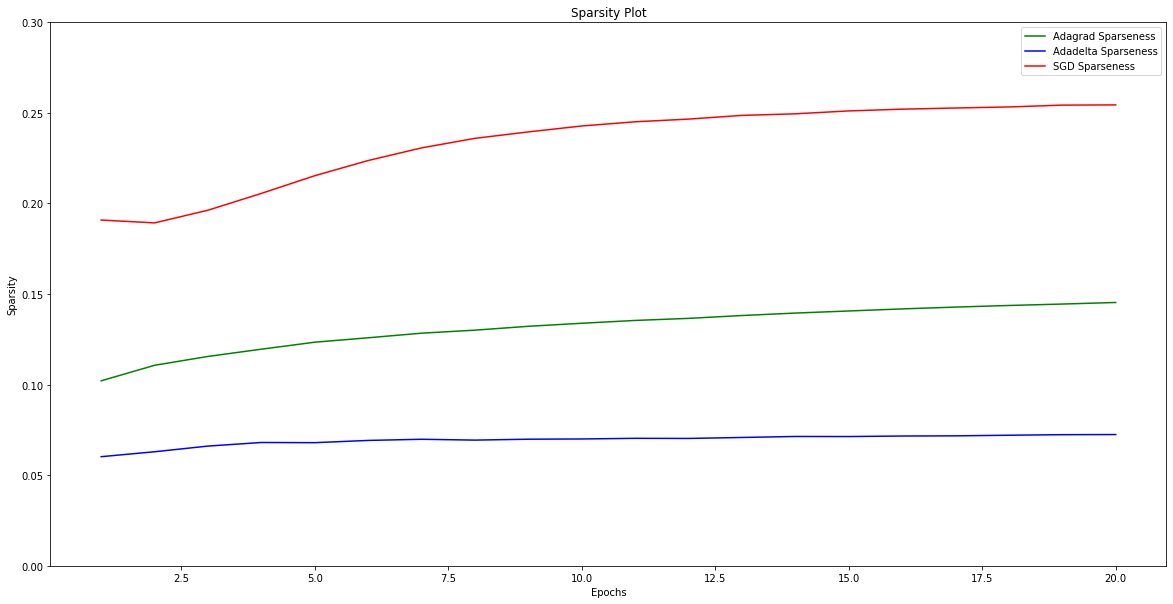

In [11]:
fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, 20+1), adagrad_sparseness_list, label="Adagrad Sparseness", color='g')
plt.plot(np.arange(1, 20+1), adadelta_sparseness_list, label="Adadelta Sparseness", color='b')
plt.plot(np.arange(1, 20+1), sgd_sparseness_list, label="SGD Sparseness", color='r')
plt.xlabel('Epochs')
plt.ylabel('Sparsity')
plt.ylim(0, 0.3)
plt.title("Sparsity Plot")
plt.legend(loc='best')
plt.show()

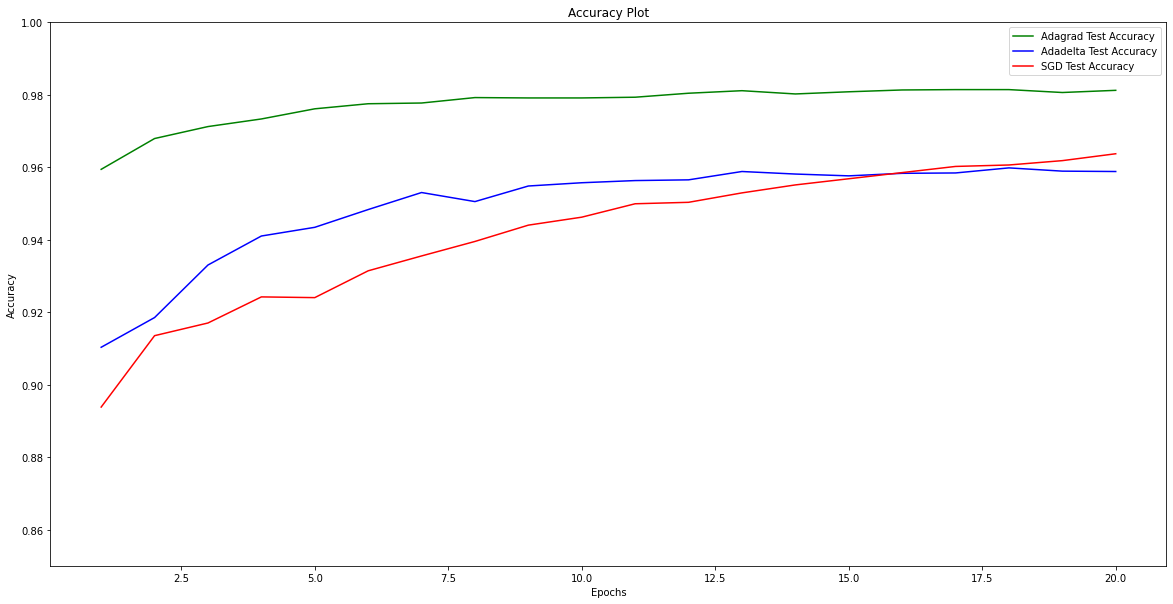

In [10]:
fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, 20+1), adagrad_test_acc, label="Adagrad Test Accuracy", color='g')
plt.plot(np.arange(1, 20+1), adadelta_test_acc, label="Adadelta Test Accuracy", color='b')
plt.plot(np.arange(1, 20+1), sgd_test_acc, label="SGD Test Accuracy", color='r')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.85, 1)
plt.title("Accuracy Plot")
plt.legend(loc='best')
plt.show()